# Imports and Reading Data

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
# Let us start by importing the library from the package directory
import pandas as pd
import numpy as np

import nltk
import re

from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Downloading all the requirements
!pip install scikit-multilearn
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Read the data
df_train = pd.read_csv("drive/MyDrive/MLProject/train.csv")
df_test = pd.read_csv("drive/MyDrive/MLProject/test.csv")

# Cosmetics for matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Setting global parameters for the Plots
rcParams['figure.figsize'] = 18, 9 
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing

In [120]:
# Check the first five rows of our dataset
df_train.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [121]:
#check the first element of the text column
df_train['text'].iloc[0]

'", 6 December 2007 (UTC)\nI am interested, not in arguing, but in the policies which resolve our ongoing content dispute. Also, see Wikipedia: WikiProject United States presidential elections for what I\'ll be working on. Also, the moneybomb closer just self-reverted on two different requests, which echoed what I would have requested.  I will rephrase #3, which I didn\'t see an answer to, building on our agreement that ""moneybomb"" should not be a redlink: Given the deletion reversion, what should be the outline of the article called ""moneybomb"" or should it be submitted for AFD again in due time? (If the latter, see the previous version of #3.) However, this version will require a detailed answer because any ambiguity will only necessitate clarifying questions.   22:32"'

In [122]:
#let us check the count, mean, std and other params of the data
df_train.describe()

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Basic text preprocessing





1.   Remove URLs, HTML Tags, Non-Alphanumeric characters, extra whitespaces, lowercase
2.   Lemmatize
3.   Remove Stopwords
4.   Remove words with length <= 2

In [123]:
class preprocess:

    def __init__(self):
        pass

    def clean(self, df, column):
      
        # applying all the methods in sequence
        df[column]= df[column].apply(self.rm_urls)
        df[column]= df[column].apply(self.rm_html_tags)
        df[column] = df[column].apply(self.rm_non_alpha)
        df[column] = self.rm_whitespace(df, column)

        # lowercasing the text
        df[column] = df[column].str.lower()

        df = self.lemmatization(df, column)
        df[column] = self.rm_stopwords(df, column)
        df = self.remove_less_2(df, column)
    
        return df

    def rm_urls(self, text):
        return re.sub(r'http\S+', ' ', text)
    
    def rm_html_tags(self, text):
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def rm_non_alpha(self, text):
        return re.sub('[^a-zA-Z]', ' ', text)

    def rm_whitespace(self, df, column):
        return df[column].apply(lambda x : " ".join(x.split()))

    def lemmatization(self, df, column):
        lemma = WordNetLemmatizer()

        # Lemmatizing with respect to the verb form and noun form
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))
        df[column] = df[column].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))

        return df

    def rm_stopwords(self, df, column):

        # Generating all the stop words of english and removing no,not nor as they are significantly important
        stop = stopwords.words('english')
        not_stop_words = {'no', 'not', 'nor'}
        modified_stop = [ele for ele in stop if ele not in not_stop_words]

        return df[column].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))

    # As the words with less than length 2 will not contribute to toxicity in a general manner
    def _clean_small(self, text):
        return re.sub(r'\b\w{1,2}\b', '', text)

    # After every re.sub we get varied amount of whitespaces so it is essential to remove white spaces
    def remove_less_2(self, df, column):
        df[column] = df[column].apply(self._clean_small)
        df[column] = self.rm_whitespace(df, column)
        return df

In [124]:
df_train = preprocess().clean(df_train, 'text')
df_test = preprocess().clean(df_test, 'text')

In [125]:
df_train['text'].iloc[0]

'december utc interest not argue policy resolve ongoing content dispute also see wikipedia wikiproject unite state presidential election work also moneybomb closer self revert two different request echo would request rephrase see answer build agreement moneybomb not redlink give deletion reversion outline article call moneybomb submit afd due time latter see previous version however version require detail answer ambiguity necessitate clarify question'

# Todo
1. Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon'.We will remove all such words which has three consecutive repeating characters.**

2. stopwords without (no not aur nor)**

# EDA (Exploratory Data Analysis)

### Count of comments per category

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

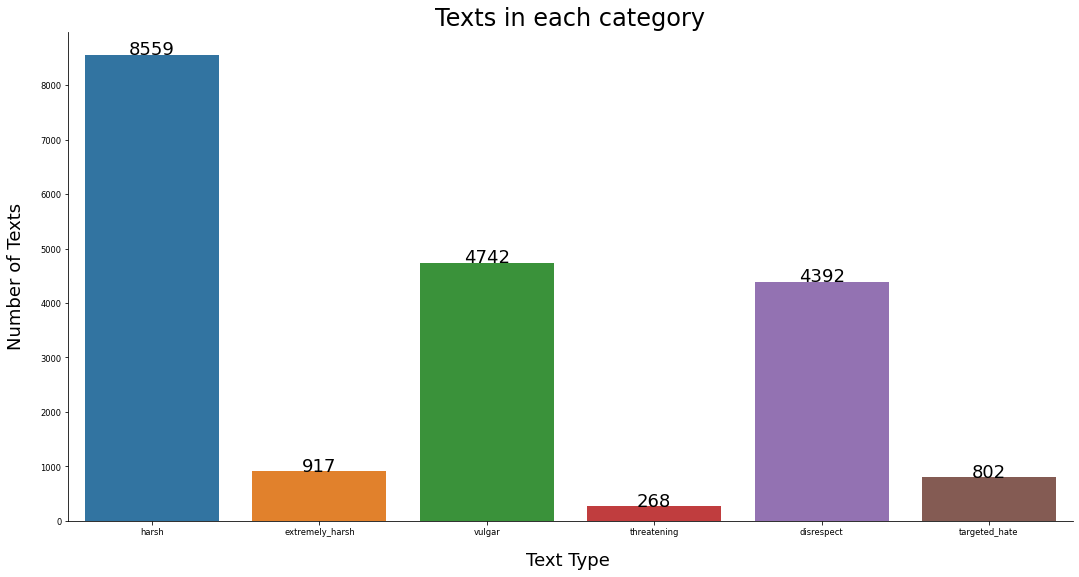

In [126]:
# List all the target columns
categories = list(df_train.columns.values)
categories.remove('id')
categories.remove('text')

#Plot
ax = sns.barplot(x=categories, y=df_train.iloc[:, 2:].sum().values)

#Labelling
plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

#For accessing the subplots in the graph
rects = ax.patches

category_values = df_train.iloc[:, 2:].sum().values

#For each subplot we need to assign a x coordinate, y coordinate and label with the orientation and fontsize
for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)

plt.show()

**Observations**: Harsh is the most common type of text and is nearly equal to the sum of all other types of texts whereas threatening, extremely_harsh, targeted_hate are the rare ones among all of them. Some more interdependent labels will be discussed in later part of the module.

### Count of comments with multiple labels

Now let us count the number of comments having multiple labels.

In [127]:
# Finding the rows which correspond to the toxic comments by looking at the toxic column's values.
df_toxic = df_train[(df_train[['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']] > 0).any(axis=1)]
len(df_toxic)

9076

There are only 9076 "Toxic comments" out of 89,359 total comments.

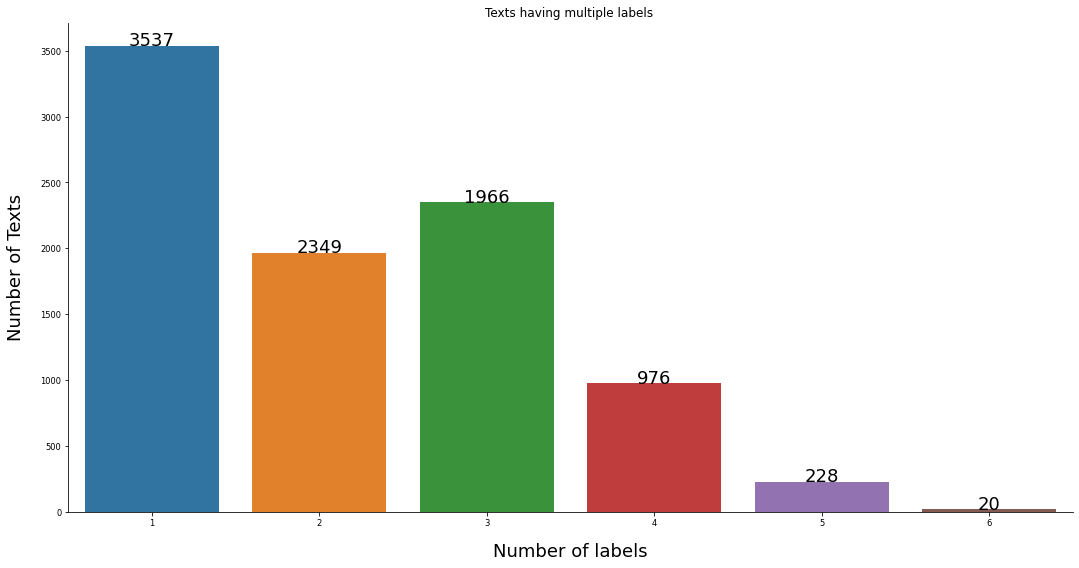

In [128]:
#Sums of the toxic columns for each row
rowSums = df_train.iloc[:, 2:].sum(axis=1)

# corresponding value counts for number of toxic labels
multiLabel_counts = rowSums.value_counts()

#Taking all the non-zero aka toxic comments counts only
multiLabel_counts = multiLabel_counts.iloc[1:]

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
category_values = multiLabel_counts.values

for rect, label in zip(rects, category_values):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), label, ha='center', fontsize=18)
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

### Top words

Now, let us find the top 100 words by frequency (for toxic comments only)

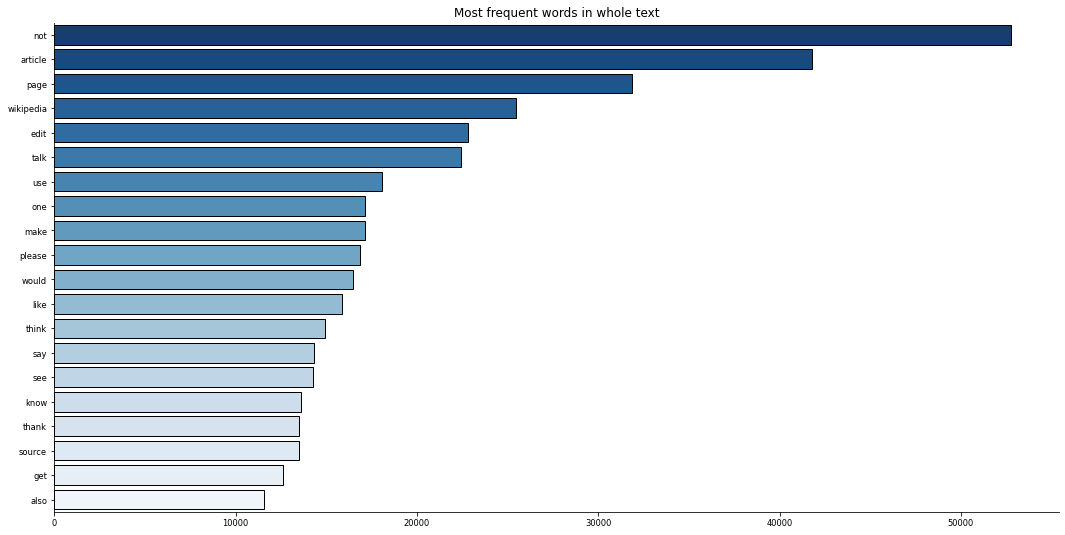

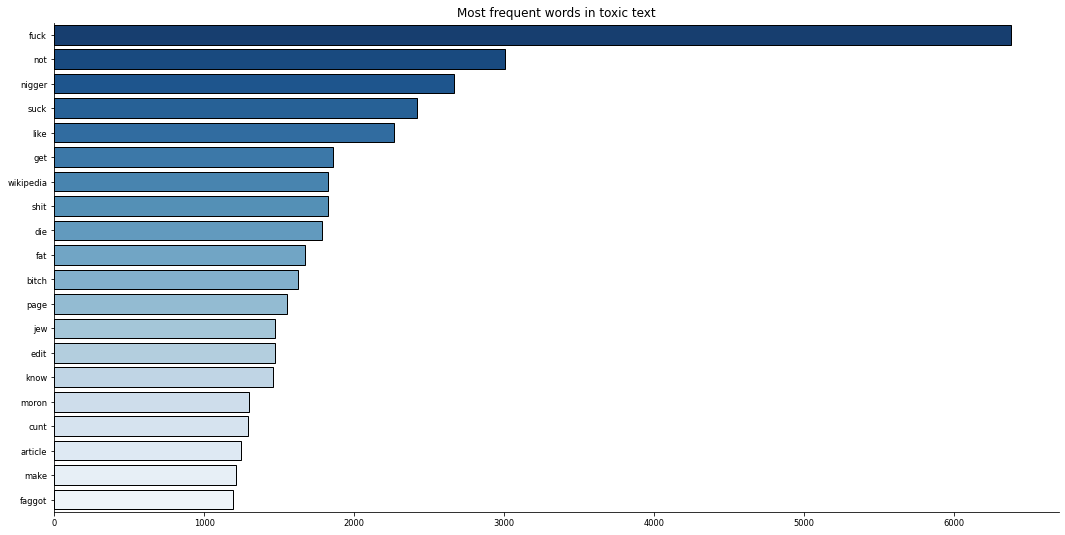

In [129]:
# value counts of each word in all the sentences.
list_words = pd.Series(' '.join(df_train.text).lower().split()).value_counts()
toxic_words = pd.Series(' '.join(df_toxic.text).lower().split()).value_counts()

sns.barplot(y=list_words.iloc[:20].index, x=list_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in whole text")
plt.show()

ax = sns.barplot(y=toxic_words.iloc[:20].index, x=toxic_words.iloc[:20].values, palette='Blues_r', edgecolor="k", linewidth=1)
plt.title("Most frequent words in toxic text")
plt.show()

**Observation**: "Clean" words are more frequent than "Toxic" words. This was expected because only about 10% comments are toxic.

### Wordcloud

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

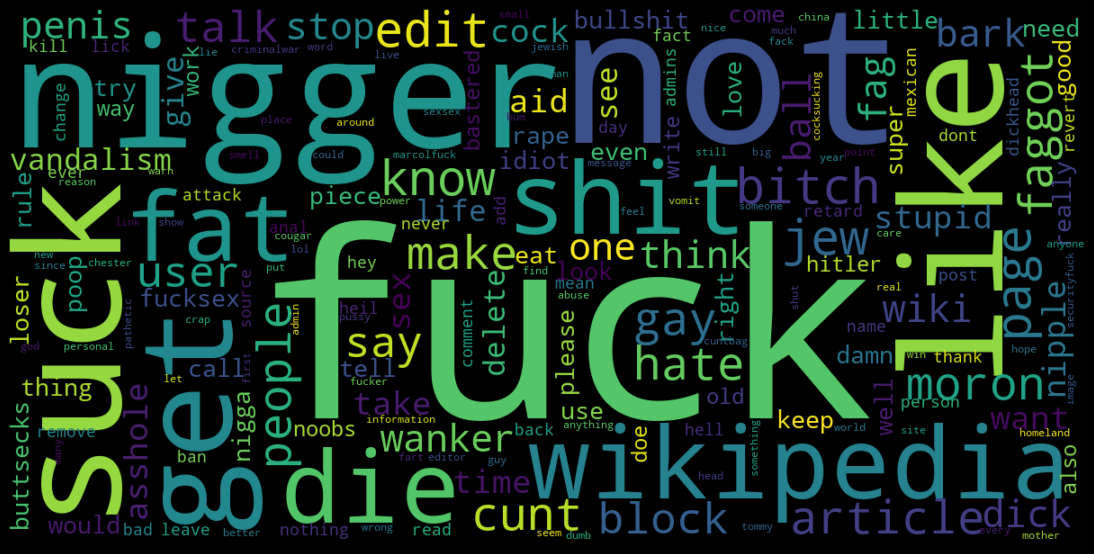

In [130]:
def generate_word_cloud(text):
    wordcloud = WordCloud(background_color = 'black', scale=3).generate_from_frequencies(text)

    fig = plt.figure(figsize = (15, 15), facecolor = 'black', edgecolor = 'black')
    
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

generate_word_cloud(toxic_words)

### Length of Comments

Next, we will plot the length of comments. We can observe that most comments are less than 500 characters long.

Text(0, 0.5, 'Count of Comments')

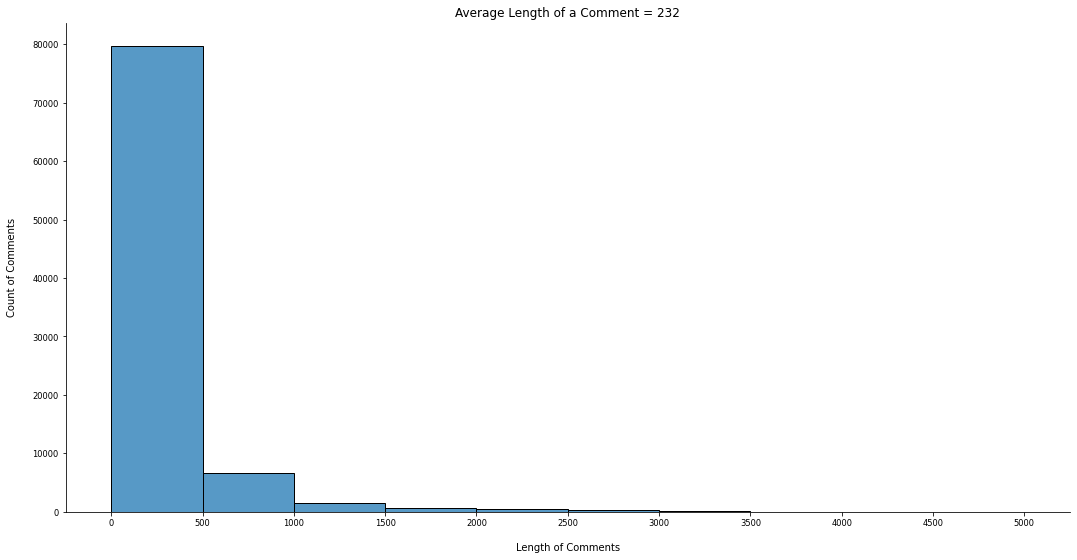

In [131]:
text_len = df_train.text.str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())))
plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=500)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Text -> Features

### TF-IDF (Term Frequency and Inverse document Frequency)

In [132]:
# list_words[list_words.index.str.startswith('fuc')]

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Explore other parameters of TfidVectorizer
vectorizer = TfidfVectorizer(binary=True, max_features=35000)

# Learn vocabulary and idf from training docs. Returns document-term matrix
TF_IDF_train = vectorizer.fit_transform(df_train['text'])

# Tranaform test docs to document-term matrix
TF_IDF_test = vectorizer.transform(df_test['text'])

In [134]:
vectorizer.get_feature_names()

# Spell Check necessary?

['aaa',
 'aaaawwww',
 'aaahhh',
 'aaand',
 'aabove',
 'aac',
 'aachen',
 'aah',
 'aai',
 'aaliyah',
 'aamir',
 'aap',
 'aardvark',
 'aarem',
 'aaron',
 'aaroncrick',
 'aarp',
 'aat',
 'aau',
 'aave',
 'aba',
 'aback',
 'abacus',
 'abad',
 'abaddon',
 'abagnale',
 'abandon',
 'abandonment',
 'abandonou',
 'abbas',
 'abbasid',
 'abbe',
 'abberations',
 'abbey',
 'abbot',
 'abbott',
 'abbreviate',
 'abbreviation',
 'abby',
 'abbywinters',
 'abc',
 'abcde',
 'abce',
 'abd',
 'abdel',
 'abdi',
 'abdication',
 'abdomen',
 'abdominal',
 'abduct',
 'abduction',
 'abdul',
 'abdulla',
 'abdullah',
 'abdur',
 'abe',
 'abecedare',
 'abedin',
 'abel',
 'abele',
 'abercromby',
 'aberdeen',
 'aberration',
 'abertura',
 'abet',
 'abettor',
 'abf',
 'abhi',
 'abhira',
 'abhishek',
 'abhor',
 'abhorrent',
 'abi',
 'abide',
 'abigail',
 'ability',
 'abiogenesis',
 'abiogenic',
 'abit',
 'abject',
 'abkhaz',
 'abkhazia',
 'ablaze',
 'able',
 'ablum',
 'ably',
 'abney',
 'abnormal',
 'abnormality',
 'abnor

In [135]:
# vectorizer.vocabulary_

# Train-Test Split

In [141]:
Y_train = df_train.drop(columns=["id", "text"]).to_numpy()

Y = df_train.drop(columns=["id", "text"]).to_numpy()

In [142]:
X_train = TF_IDF_train
X_test = TF_IDF_test

In [138]:
# from skmultilearn.model_selection import iterative_train_test_split

# X_train, Y_train, X_test, Y_test = iterative_train_test_split(TF_IDF_train, Y, test_size = 0.2)

In [139]:
# print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# Model Selection and Training

This is a <b>multi-label classification</b> problem (Text can be classified into multiple labels simultaneosly or none)

NOTE - This is different from <b>multi-class classification</b> in which the sample is assigned to only a single class from the pool of multiple classes.

## OneVsRest

### Logistic Regression

Training

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = []

#Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  LR.append(LogisticRegression(solver='newton-cg').fit(X_train, Y_train[:, i]))

Inference - Train data

In [144]:
Y_train_pred = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred[:, i] = LR[i].predict(X_train)

In [145]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

In [146]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)

0.6899687431331857

In [147]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9902996413018195

Inference - Test data

In [148]:
Y_test_pred = np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_test_pred[:, i] = LR[i].predict(X_test)

In [150]:
Y_test_pred_prob = np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_test_pred_prob[:, i] = LR[i].predict_proba(X_test)[:, 1]

In [151]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred)

ValueError: ignored

In [152]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

ValueError: ignored

### GridSearchCV

In [156]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1,scoring = 'roc_auc')

GSCV = []

#Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  print(i)
  best_clf=clf.fit(X_train, Y_train[:, i])
  # GSCV.append(clf.fit(X_train, Y_train[:, i]))
  print("END")
  print(best_clf.best_estimator_)

0
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


In [ ]:
# Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

# for i in range(Y_train.shape[1]):
#   Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

### Random Forest

Training

In [32]:
from sklearn.ensemble import RandomForestClassifier

RF =[]

#Making RF list for all the 6 target columns and applying Random forest classifier on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  print(i)
  RF.append(RandomForestClassifier(max_depth=100,n_estimators=200,min_samples_leaf=50).fit(X_train, Y_train[:, i]))

0
1
2
3
4
5


Inference - Train data

In [33]:
Y_train_pred = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred[:, i] = RF[i].predict(X_train)

In [34]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = RF[i].predict_proba(X_train)[:, 1]

In [35]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)

0.5497089138785043

In [36]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9762896043844211

Inference - Test data

In [37]:
Y_test_pred_prob = np.ones((Y_test.shape[0], Y_test.shape[1]))

for i in range(Y_test.shape[1]):
  Y_test_pred_prob[:, i] = RF[i].predict_proba(X_test)[:, 1]

In [38]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

0.9624540606831337

## XGBoost

In [41]:
import xgboost as xgb

XGBarray = []

#Making LR list for all the 6 target columns and applying logistic regression on all of them considering they are independent  
for i in range(Y_train.shape[1]):
  print(i)
  XGBarray.append(xgb.XGBClassifier().fit(X_train, Y_train[:, i]))

0
1
2
3
4
5


In [42]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = XGBarray[i].predict_proba(X_train)[:, 1]

In [43]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9620924993150686

In [44]:
Y_test_pred_prob = np.ones((X_test.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_test_pred_prob[:, i] = XGBarray[i].predict_proba(X_test)[:, 1]

In [45]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

0.9478413317417432

# Exporting test predictions

In [153]:
#Assigning the columns to the obtained data
df_export = pd.DataFrame(data=Y_test_pred_prob, columns=["harsh", "extremely_harsh","vulgar","threatening","disrespect","targeted_hate"])

In [154]:
#appending id in the start
df_export.insert(loc=0, column='id', value=df_test['id'])

In [155]:
#exporting it in the end
df_export.to_csv('prediction.csv',index=False)